In [2]:
# Продолжайте развитие и анализ сгененированных данных.
# 4.1. На выбор, реализация текстурных характеристик:
#  - Признаки Тамура
#  - матрица взаимной встречаемости
# 4.2. На выбор, реализация алгоритма сегментации при помощи выбранного алгоритма кластеризации данных: 
# https://scikit-learn.ru/stable/modules/clustering.html
# 4.2.1 Если в кодировке пикселя не использовали его положение, выделите связные регионы.
# 4.3. На выбор, рассчитайте Качество проведенной сегментации на основе характеристик качества кластеризации: 
# https://scikit-learn.ru/stable/modules/clustering.html#clustering-evaluation 
# 4.4. Визуализируйте результат сегментации
# 4.5 Рассчитайте характеристики(описание формы) объектов.
# 4.6 Используя алгоритм кластеризации, найдите количество классов объектов на изображении.


=== Обработка изображения 1 ===
Текстурные характеристики: {'contrast': np.float64(0.5259420955882353), 'energy': np.float64(0.4554757151470981)}
Найдено объектов: 139, средняя площадь: 2259.6
Оценка сегментации (Silhouette): 0.7262677865298246


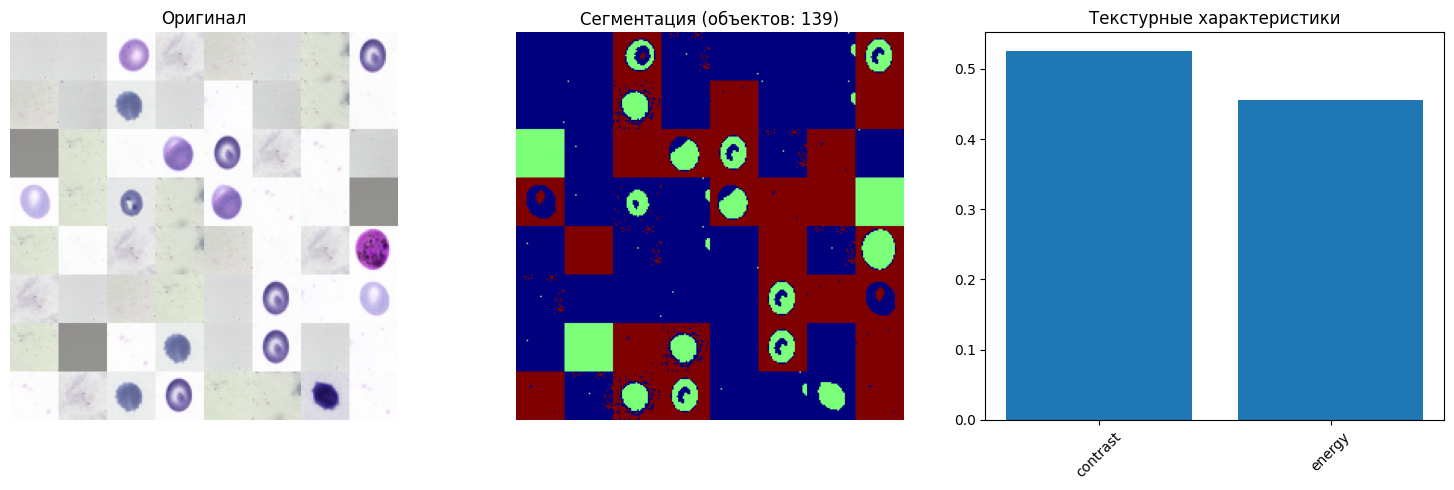

Время обработки: 2.04 сек

=== Обработка изображения 2 ===
Текстурные характеристики: {'contrast': np.float64(0.49167432598039207), 'energy': np.float64(0.4613977412402022)}
Найдено объектов: 152, средняя площадь: 1736.6
Оценка сегментации (Silhouette): 0.7548721502559674


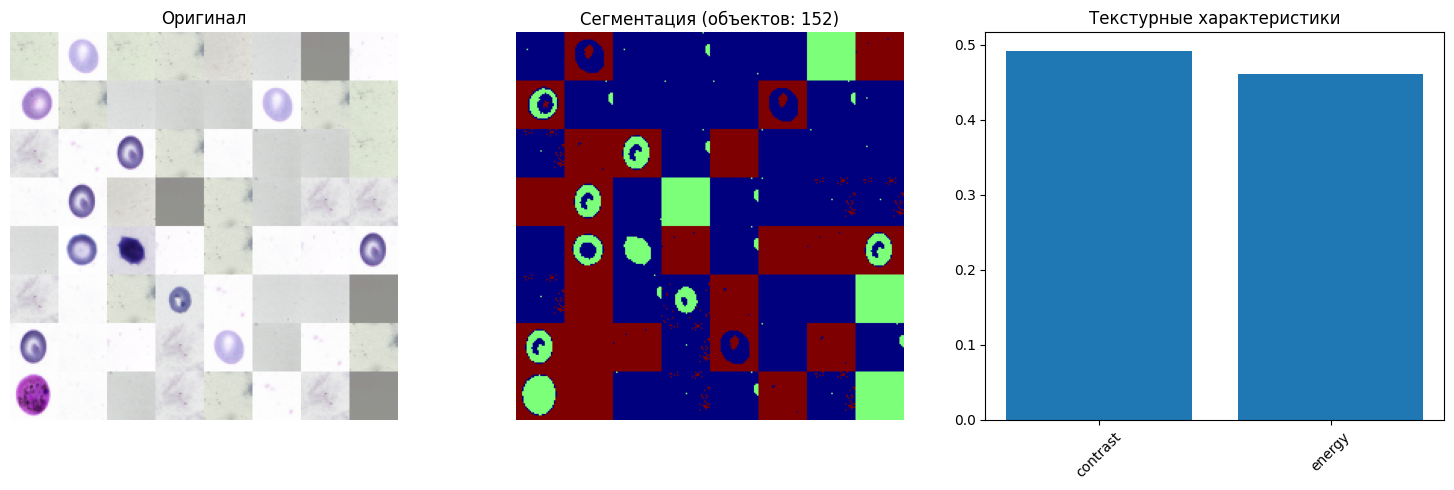

Время обработки: 1.46 сек

=== Обработка изображения 3 ===
Текстурные характеристики: {'contrast': np.float64(0.26717984068627443), 'energy': np.float64(0.5125695917148849)}
Найдено объектов: 32, средняя площадь: 10617.8
Оценка сегментации (Silhouette): 0.7897630578280724


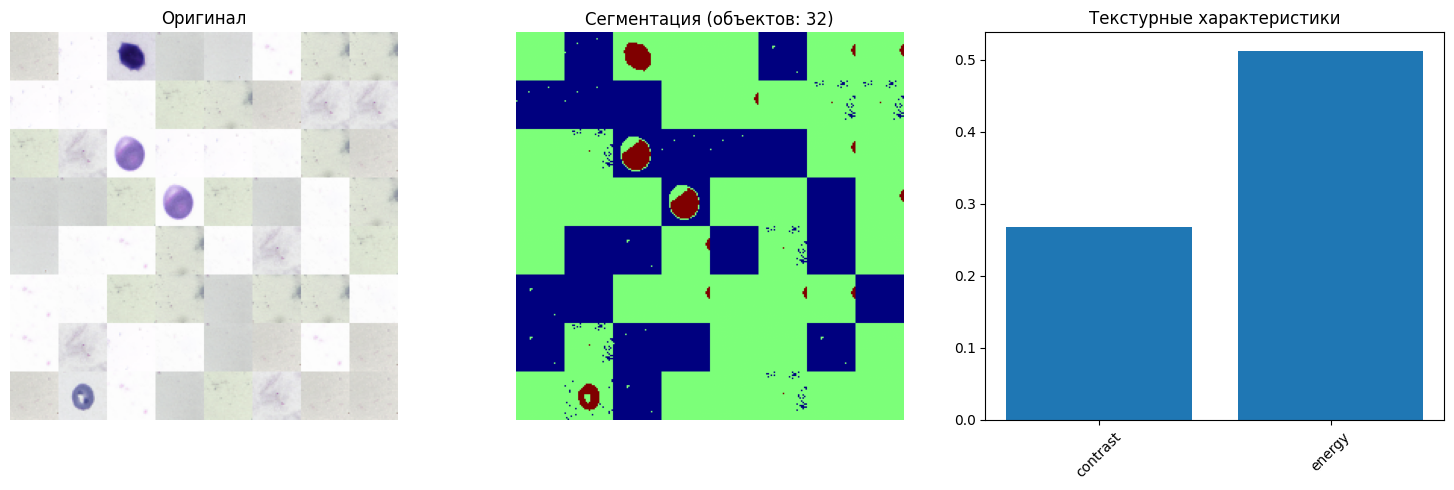

Время обработки: 1.46 сек

=== Обработка изображения 4 ===
Текстурные характеристики: {'contrast': np.float64(0.5019454656862744), 'energy': np.float64(0.4627222291123859)}
Найдено объектов: 110, средняя площадь: 4605.3
Оценка сегментации (Silhouette): 0.766297003136954


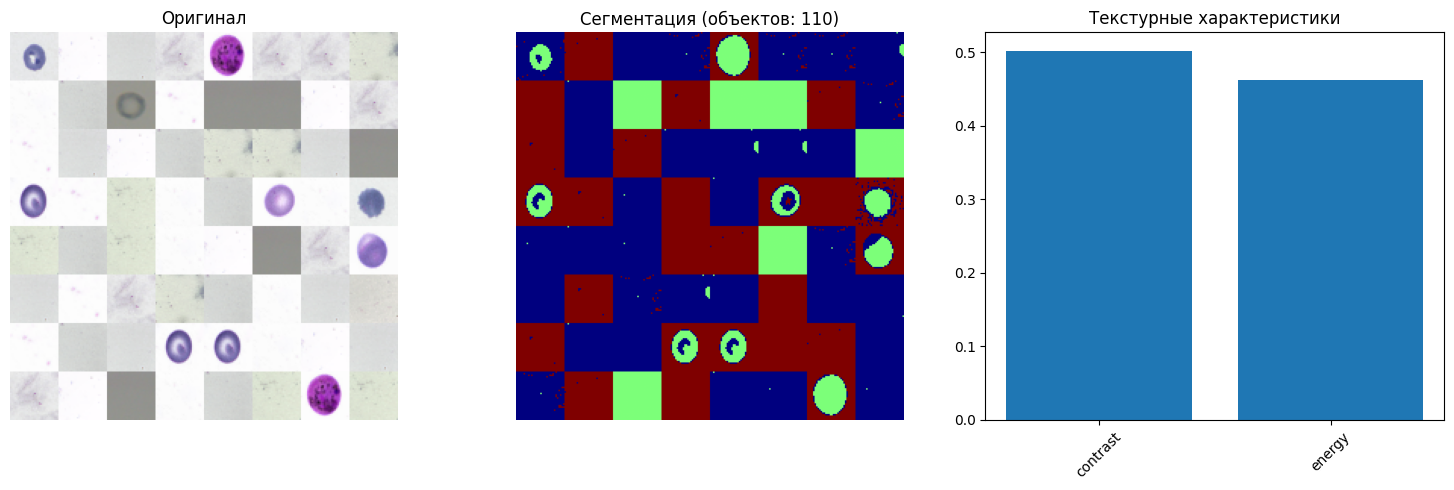

Время обработки: 1.45 сек

=== Обработка изображения 5 ===
Текстурные характеристики: {'contrast': np.float64(0.41603860294117634), 'energy': np.float64(0.4981794622749713)}
Найдено объектов: 52, средняя площадь: 5763.4
Оценка сегментации (Silhouette): 0.7867838974744431


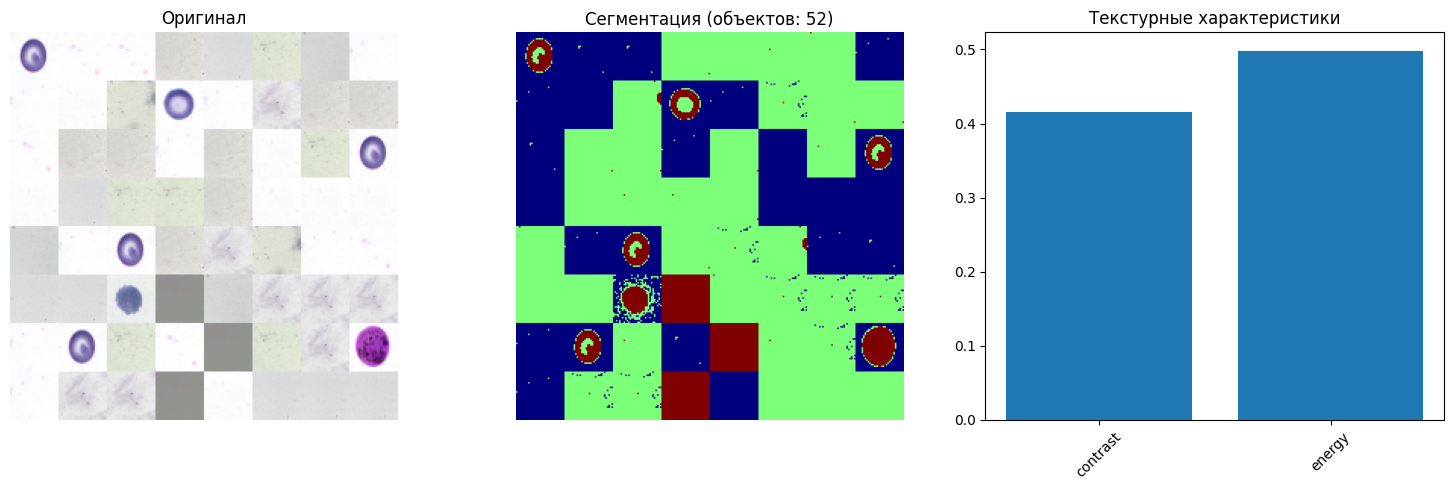

Время обработки: 1.59 сек


In [ ]:
import cv2
import os
import numpy as np
import matplotlib.pyplot as plt
from skimage import feature, measure
from sklearn.cluster import KMeans, MiniBatchKMeans
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import silhouette_score
from skimage.filters import threshold_otsu
import time

def load_and_preprocess_images():
    """Загрузка и предварительная обработка изображений"""
    images = []
    input_dir = 'blood_cells/dataset/clear'
    
    for i in range(1, 6):
        img_path = os.path.join(input_dir, f'clear_image_{i}.png')
        img = cv2.imread(img_path)
        if img is not None:
            # Уменьшаем размер изображения для обработки
            img = cv2.resize(img, (256, 256))
            images.append(img)
        else:
            print(f"Не удалось загрузить изображение {i}")
    return images

def extract_glcm_features(img):
    """Оптимизированное извлечение GLCM характеристик"""
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    gray = (gray / 16).astype(np.uint8)  # Уменьшаем количество уровней интенсивности
    
    distances = [1]
    angles = [0, np.pi/2]  # Только 0 и 90 градусов для ускорения
    glcm = feature.graycomatrix(gray, distances=distances, angles=angles, 
                              levels=16, symmetric=True, normed=True)
    
    contrast = feature.graycoprops(glcm, 'contrast').mean()
    energy = feature.graycoprops(glcm, 'energy').mean()
    
    return {'contrast': contrast, 'energy': energy}

def segment_kmeans_fast(img, n_clusters=3):
    """Быстрая сегментация с использованием MiniBatchKMeans"""
    h, w = img.shape[:2]
    pixels = img.reshape(-1, 3).astype(np.float32)
    
    # Используем MiniBatchKMeans для больших изображений
    kmeans = MiniBatchKMeans(n_clusters=n_clusters, random_state=42, batch_size=1000)
    labels = kmeans.fit_predict(pixels)
    
    return labels.reshape(h, w)

def segment_adaptive_threshold(img):
    """Сегментация с адаптивным порогом"""
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    thresh = threshold_otsu(gray)
    binary = gray > thresh
    return binary.astype(int)

def evaluate_segmentation_simple(img, labels):
    """Упрощенная оценка сегментации"""
    unique_labels = np.unique(labels)
    if len(unique_labels) > 1:
        # Используем только silhouette score для экономии памяти
        pixels = img.reshape(-1, 3)[::10]  # Берем каждый 10-й пиксель
        labels_sampled = labels.reshape(-1)[::10]
        silhouette = silhouette_score(pixels, labels_sampled)
    else:
        silhouette = -1
    return {'silhouette': silhouette}

def find_and_analyze_components(labels):
    """Поиск и анализ связных компонент"""
    binary = (labels > 0).astype(np.uint8)
    num_labels, labeled_image = cv2.connectedComponents(binary)
    
    if num_labels > 1:
        regions = measure.regionprops(labeled_image)
        areas = [r.area for r in regions if r.area > 10]  # Игнорируем мелкие объекты
        mean_area = np.mean(areas) if areas else 0
    else:
        mean_area = 0
    
    return num_labels - 1, mean_area  # Исключаем фон

def visualize_results_simple(original, segmented, features, evaluation, n_objects):
    """Упрощенная визуализация"""
    plt.figure(figsize=(15, 5))
    
    plt.subplot(1, 3, 1)
    plt.imshow(cv2.cvtColor(original, cv2.COLOR_BGR2RGB))
    plt.title('Оригинал')
    plt.axis('off')
    
    plt.subplot(1, 3, 2)
    plt.imshow(segmented, cmap='jet')
    plt.title(f'Сегментация (объектов: {n_objects})')
    plt.axis('off')
    
    plt.subplot(1, 3, 3)
    plt.bar(features.keys(), features.values())
    plt.title('Текстурные характеристики')
    plt.xticks(rotation=45)
    
    plt.tight_layout()
    plt.show()

def process_images_optimized():
    """Оптимизированная обработка изображений"""
    images = load_and_preprocess_images()
    
    for i, img in enumerate(images, 1):
        print(f"\n=== Обработка изображения {i} ===")
        start_time = time.time()
        
        # 1. Текстурные характеристики
        features = extract_glcm_features(img)
        print("Текстурные характеристики:", features)
        
        # 2. Сегментация 
        segmented = segment_kmeans_fast(img, n_clusters=3)
        
        # 3. Анализ связных компонент
        n_objects, mean_area = find_and_analyze_components(segmented)
        print(f"Найдено объектов: {n_objects}, средняя площадь: {mean_area:.1f}")
        
        # 4. Оценка сегментации
        evaluation = evaluate_segmentation_simple(img, segmented)
        print("Оценка сегментации (Silhouette):", evaluation['silhouette'])
        
        # 5. Визуализация
        visualize_results_simple(img, segmented, features, evaluation, n_objects)
        
        print(f"Время обработки: {time.time() - start_time:.2f} сек")

if __name__ == "__main__":
    process_images_optimized()